<a href="https://colab.research.google.com/github/jcandane/uwmanifeld/blob/main/uwmanifeld_example.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [11]:
import jax

jax.config.update("jax_enable_x64", True)

import os
import jax, jax.numpy as jnp
import matplotlib.pyplot as plt

try:
    from jeigsh import jeigsh
    from uwmanifeld import DiffusionMap
except:
    os.system("wget https://raw.githubusercontent.com/jcandane/uwmanifeld/main/jeigsh.py")
    os.system("wget https://raw.githubusercontent.com/jcandane/uwmanifeld/main/uwmanifeld.py")
    from jeigsh import jeigsh
    from uwmanifeld import DiffusionMap

try:
    from gym_rings import get_rings
except:
    os.system("wget https://raw.githubusercontent.com/jcandane/uwmanifold/main/gym_rings.py")
    from gym_rings import get_rings

try:
    R_ix = jnp.load("saxs_highq_100k.npy")
except:
    os.system("wget https://huggingface.co/datasets/jcandane/rings/resolve/main/saxs_highq_100k.npy")
    R_ix = jnp.load("saxs_highq_100k.npy")

#!git clone https://github.com/jcandane/uwmanifold.git

import numpy as np
import scipy

def DiffusionMap_old(R_ix, k=2):
    R_ix = np.asarray(R_ix)

    ### Compute the pairwise distance matrix
    D2 = scipy.spatial.distance.cdist(R_ix, R_ix, 'sqeuclidean')

    ### Choose an appropriate kernel scale parameter (σ)
    σ2 = np.mean(D2)

    ##### PART of LinearOperator
    ### Construct the affinity matrix (kernel)
    P = np.exp( - D2 / (2. * σ2))

    ### Normalize the affinity matrix (Row-normalization)
    row_sums  = np.sum( P, axis=1 )
    P        @= np.diag(1.0 / row_sums)
    #####

    ### Krylov-Subspace Methods
    eigenvalues, eigenvectors = scipy.sparse.linalg.eigsh(P, k=(1+k))
    idx           = np.argsort(eigenvalues)[::-1] ## sort the eigenvalues
    eigenvalues  = eigenvalues[idx]
    eigenvectors = eigenvectors[:, idx]
    embedding    = eigenvectors[:, 1:(1+k)]
    return embedding

## equally spaced icons

(360, 128, 128)
(360, 16384)


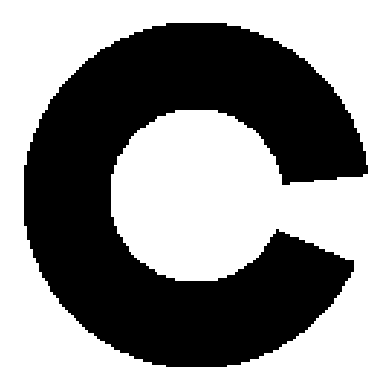

In [27]:
θs    = jnp.arange(0,360,1).reshape(-1,1).T
R_ixy = get_rings(128, θs, jnp.array([[30,60]]), notch_width=15.)
print(R_ixy.shape)
R_iz  = R_ixy.reshape(θs.size,-1)
R_iz  = R_iz[np.random.permutation(R_iz.shape[0]), :]
print(R_iz.shape)

plt.imshow(R_ixy[-8], interpolation='none', cmap='Greys')
plt.axis("off")
plt.show()

In [ ]:
embedding = DiffusionMap(R_iz, k=8, σ=111.1, c=1, α=1.0)

embedding_old = DiffusionMap_old(R_iz, k=8)

plt.scatter(embedding[:,0], embedding[:,1])
plt.scatter(embedding_old[:,0], embedding_old[:,1])
plt.axis("equal")
plt.show()

## non-equal spacing

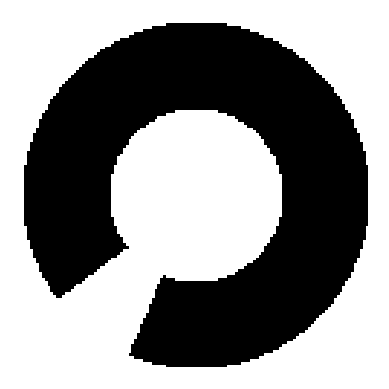

In [28]:
θs    = jnp.arange(0,600,1).reshape(-1,1).T
R_ixy = get_rings(128, θs, jnp.array([[30,60]]), notch_width=15.)
R_iz  = R_ixy.reshape(θs.size,-1)
R_iz  = R_iz[np.random.permutation(R_iz.shape[0]), :]

plt.imshow(R_ixy[-8], interpolation='none', cmap='Greys')
plt.axis("off")
plt.show()

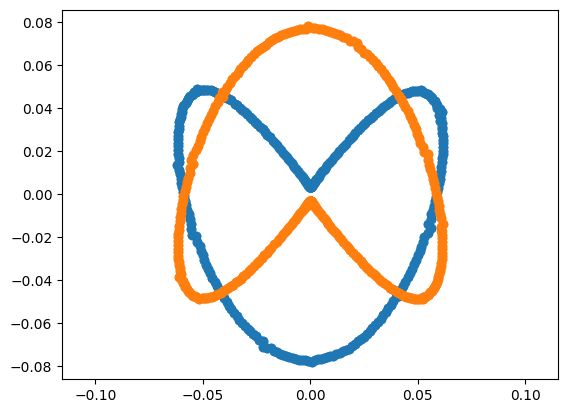

In [26]:
embedding = DiffusionMap(R_iz, k=8, σ=111.1, c=1, α=1.0)

embedding_old = DiffusionMap_old(R_iz, k=8)

plt.scatter(embedding[:,0], embedding[:,1])
plt.scatter(embedding_old[:,0], embedding_old[:,1])
plt.axis("equal")
plt.show()

In [23]:
print( R_ix.shape, type(R_ix), R_ix.devices(), R_ix.dtype )
R_ix.shape

(100000, 300) <class 'jaxlib.xla_extension.ArrayImpl'> {cuda(id=0)} float32


(100000, 300)

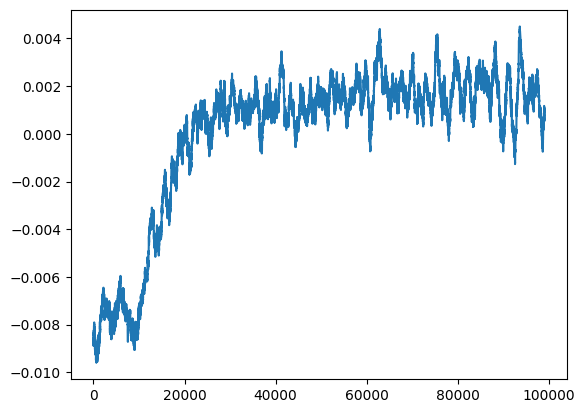

In [24]:
embedding = DiffusionMap(R_ix, k=6, c=2**10)

plt.plot(embedding[:,0])
plt.show()

In [25]:
%timeit DiffusionMap(R_ix, c=1)
%timeit DiffusionMap(R_ix, k=6, c=2**8)

271 ms ± 743 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)
12.6 s ± 76.6 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
